# Sequence Prediction: Surname Generation

In this experiment, you will explore a simple sequence prediction task: Text generation using a Gated Recurrent Unit (GRU). Like the LSTM, this is a  gated recurrent neural network, but since it has fewer parameters, it should be more appropriate for a smaller dataset.

The GRU computes a probability distribution over the set of possible characters in the surname vocabulary for each time step. We use these probability distributions to generate new surnames. You are given a starter code, that trains a SurnameGenerationModel on the [surname dataset](https://github.com/jasoriya/CS6120-PS2-support/blob/master/data/surnames/surnames_with_splits.csv) to generate new surnames by learning from the training data. 



Your task is to understand this code and plot the over all perplxity of GRU model as a function of the hidden representation size (K) and the number of characters already observed. You will see **TODO** prompts in the following cells

## Imports

In [0]:
import os
from argparse import Namespace

import numpy as np
import httpimport
import torch
import torch.optim as optim
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


# import data preprocessing and modeling functions from https://github.com/jasoriya/CS6120-PS2-support/tree/master/utils
with httpimport.remote_repo(['data_vectorization','model','helper'], 'https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/utils/'):
  from data_vectorization import Vocabulary, SequenceVocabulary, SurnameVectorizer, SurnameDataset, generate_batches
  from model import SurnameGenerationModel, sample_from_model, decode_samples
  from helper import make_train_state, update_train_state, normalize_sizes, compute_accuracy, sequence_loss, set_seed_everywhere, handle_dirs


### Settings and some prep work

**TODO**: 
- Give path to a directory where the model should be saved
- Give hidden state size (`rnn_hidden_size`) for the GRU model (experiment with different levels)


**TODO**: Write code to compute the perplexity of the whole text corpus, the accuracy of a character-prediction task, and the perplexity at a given character position (1, 2, 3, ...).

In [0]:
def multiple_rnn(rnn):
    args = Namespace(
        # Data and Path information
        surname_csv="https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv",
        vectorizer_file="vectorizer.json",
        model_state_file="model.pth",
        save_dir="./sample_data/" + str(rnn),  # give path here is for google clob in smaple data folder with the RNN value as sub folder
        # Model hyper parameters
        char_embedding_size=32,
        rnn_hidden_size=rnn,  # RNN value is passed with the data
        # Training hyper parameters
        seed=1337,
        learning_rate=0.001,
        batch_size=128,
        num_epochs=100,
        early_stopping_criteria=5,
        # Runtime options
        catch_keyboard_interrupt=True,
        cuda=True,
        expand_filepaths_to_save_dir=True,
        reload_from_files=False,
    )

    if args.expand_filepaths_to_save_dir:
        args.vectorizer_file = os.path.join(args.save_dir,
                                            args.vectorizer_file)

        args.model_state_file = os.path.join(args.save_dir,
                                             args.model_state_file)

        print("Expanded filepaths: ")
        print("\t{}".format(args.vectorizer_file))
        print("\t{}".format(args.model_state_file))

    # Check CUDA
    if not torch.cuda.is_available():
        args.cuda = False

    args.device = torch.device("cuda" if args.cuda else "cpu")

    print("Using CUDA: {}".format(args.cuda))

    # Set seed for reproducibility
    set_seed_everywhere(args.seed, args.cuda)

    # handle dirs
    handle_dirs(args.save_dir)


    if args.reload_from_files:
        # training from a checkpoint
        dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                                  args.vectorizer_file)
    else:
        # create dataset and vectorizer
        dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
        dataset.save_vectorizer(args.vectorizer_file)

    vectorizer = dataset.get_vectorizer()

    model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                                   char_vocab_size=len(vectorizer.char_vocab),
                                   rnn_hidden_size=args.rnn_hidden_size,
                                   padding_idx=vectorizer.char_vocab.mask_index)
    

    mask_index = vectorizer.char_vocab.mask_index

    model = model.to(args.device)

    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                     mode='min', factor=0.5,
                                                     patience=1)
    train_state = make_train_state(args)

    epoch_bar = tqdm_notebook(desc='training routine',
                              total=args.num_epochs,
                              position=0)

    dataset.set_split('train')
    train_bar = tqdm_notebook(desc='split=train',
                              total=dataset.get_num_batches(args.batch_size),
                              position=1,
                              leave=True)
    dataset.set_split('val')
    val_bar = tqdm_notebook(desc='split=val',
                            total=dataset.get_num_batches(args.batch_size),
                            position=1,
                            leave=True)

    try:
        for epoch_index in range(args.num_epochs):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            dataset.set_split('train')
            batch_generator = generate_batches(dataset,
                                               batch_size=args.batch_size,
                                               device=args.device)
            running_loss = 0.0
            running_acc = 0.0
            model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is these 5 steps:
                # --------------------------------------
                # step 1. zero the gradients

                optimizer.zero_grad()

                # step 2. compute the output

                y_pred = model(x_in=batch_dict['x_data'])

                # step 3. compute the loss

                loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

                # step 4. use loss to produce gradients

                loss.backward()

                # step 5. use optimizer to take gradient step
                
                optimizer.step()
                # -----------------------------------------
                # compute the  running loss and running accuracy
                running_loss += (loss.item() - running_loss) / (batch_index + 1)
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
                running_acc += (acc_t - running_acc) / (batch_index + 1)

                # update bar
                train_bar.set_postfix(loss=running_loss,
                                      acc=running_acc,
                                      epoch=epoch_index)
                train_bar.update()

            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on
            dataset.set_split('val')
            batch_generator = generate_batches(dataset,
                                               batch_size=args.batch_size,
                                               device=args.device)
            running_loss = 0.
            running_acc = 0.
            model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):
                # compute the output
                y_pred = model(x_in=batch_dict['x_data'])

                # step 3. compute the loss
                loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

                # compute the  running loss and running accuracy
                running_loss += (loss.item() - running_loss) / (batch_index + 1)
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
                running_acc += (acc_t - running_acc) / (batch_index + 1)

                # Update bar
                val_bar.set_postfix(loss=running_loss, acc=running_acc,
                                    epoch=epoch_index)
                val_bar.update()

            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

            train_state = update_train_state(args=args, model=model,
                                             train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            # move model to cpu for sampling
            model = model.cpu()
            sampled_surnames = decode_samples(
                sample_from_model(model, vectorizer, num_samples=2),
                vectorizer)
            epoch_bar.set_postfix(sample1=sampled_surnames[0],
                                  sample2=sampled_surnames[1])
            # move model back to whichever device it should be on
            model = model.to(args.device)

            train_bar.n = 0
            val_bar.n = 0
            epoch_bar.update()

    except KeyboardInterrupt:
        print("Exiting loop")
    np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)
    model.load_state_dict(torch.load(train_state['model_filename']))
    print(train_state['model_filename'])
    model = model.to(args.device)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_acc = 0.
    running_loss = 0.
    model.eval()
    perplexity = {}
    accuracy = {}

    enumerated = list(enumerate(batch_generator))

    for i in range(1, len(enumerated)+1):
        for batch_index, batch_dict in enumerated:
            y_pred = model(x_in=batch_dict['x_data'][:, 0:i])
            loss = sequence_loss(y_pred, batch_dict['y_target'][:, 0:i], mask_index)
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'][:, 0:i], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
        accuracy[i] = running_acc
        perplexity[i] = torch.exp(torch.tensor(running_loss)).item()
    for k in perplexity.keys():
        print(k, "character perplexity:", perplexity[k])
        
    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc



    print("Test loss: {};".format(train_state['test_loss']))
    print("Test Accuracy: {}".format(train_state['test_acc']))


    tensorTest = torch.exp(torch.tensor(running_loss))
    tensorTrain = train_state['train_loss']
    tensorValidation = train_state['val_loss']
    print("Validation dataset perplexity;", tensorValidation[-1])
    print("Test dataset perplexity: {};".format(tensorTest.item())) 
    corpusPerplexity = (tensorTest.item() + tensorTrain[-1] + tensorValidation[-1]) 
    print("Perplexity of the entire corpus:", corpusPerplexity/3)
    model.load_state_dict(torch.load(train_state['model_filename']))
    model = model.to(args.device)



    num_names = 10
    model = model.cpu()
    # Generate nationality hidden state
    sampled_surnames = decode_samples(
        sample_from_model(model, vectorizer, num_samples=num_names),
        vectorizer)
    # Show results
    print("-" * 15)
    for i in range(num_names):
        print(sampled_surnames[i])
    return perplexity, accuracy


## Inference
To see the names that the model generates:

**TODO**: Train the GRU model given above multiple times for different levels of `rnn_hidden_size`. For each of these models, plot the average perplexity as a function of the number of characters of the name observed so far. Explain your observations.

In [0]:
def generate_plot(listRnn):
    ultimate_dict = {}
    for entry in listRnn:
        perplex_dict, acc_dict = multiple_rnn(entry)
        ultimate_dict[entry] = perplex_dict
        y1 = list(perplex_dict.values())
        x1 = list(perplex_dict.keys())
        plt.plot(x1, y1, label="RNN="+str(entry))
    plt.xlabel('Characters')
    plt.ylabel('Peplexity')
    plt.title('Perplexity VS Character')
    plt.legend()
    plt.show()

Expanded filepaths: 
	./sample_data/10/vectorizer.json
	./sample_data/10/model.pth
Using CUDA: True


./sample_data/10/model.pth
1 character perplexity: 23.89665412902832
2 character perplexity: 17.216293334960938
3 character perplexity: 18.481595993041992
4 character perplexity: 19.087800979614258
5 character perplexity: 18.911481857299805
6 character perplexity: 18.363056182861328
7 character perplexity: 17.861299514770508
8 character perplexity: 17.454050064086914
9 character perplexity: 17.108726501464844
10 character perplexity: 16.7535343170166
11 character perplexity: 16.790971755981445
12 character perplexity: 16.730606079101562
Test loss: 2.8172398606936135;
Test Accuracy: 19.067006513001857
Validation dataset perplexity; 2.7986357212066646
Test dataset perplexity: 16.730606079101562;
Perplexity of the entire corpus: 7.443728633721669
---------------
Caaolnfn
Eftelasr
Ou
Maioreni
Abzjtor
Faagömnketk
Megoda
Kokesso
A
Porirner
Expanded filepaths: 
	./sample_data/20/vectorizer.json
	./sample_data/20/model.pth
Using CUDA: True


./sample_data/20/model.pth
1 character perplexity: 22.240482330322266
2 character perplexity: 14.428359031677246
3 character perplexity: 15.906998634338379
4 character perplexity: 16.531360626220703
5 character perplexity: 16.38434600830078
6 character perplexity: 15.87060546875
7 character perplexity: 15.215677261352539
8 character perplexity: 14.775026321411133
9 character perplexity: 14.554272651672363
10 character perplexity: 14.151074409484863
11 character perplexity: 14.058646202087402
12 character perplexity: 13.990964889526367
Test loss: 2.638411819934845;
Test Accuracy: 23.50072385548234
Validation dataset perplexity; 2.63716322183609
Test dataset perplexity: 13.990964889526367;
Perplexity of the entire corpus: 6.419832385910882
---------------
Vlibin
Ejisinlrni
Keimhas
Bey
Moniro
Ksus
Biala
Razgirat
Thathdanf
Shadri
Expanded filepaths: 
	./sample_data/30/vectorizer.json
	./sample_data/30/model.pth
Using CUDA: True


./sample_data/30/model.pth
1 character perplexity: 22.09265899658203
2 character perplexity: 14.06622314453125
3 character perplexity: 15.032246589660645
4 character perplexity: 15.820140838623047
5 character perplexity: 15.40239143371582
6 character perplexity: 15.232479095458984
7 character perplexity: 14.701414108276367
8 character perplexity: 14.145188331604004
9 character perplexity: 13.776971817016602
10 character perplexity: 13.507096290588379
11 character perplexity: 13.311138153076172
12 character perplexity: 13.299184799194336
Test loss: 2.587702751159668;
Test Accuracy: 24.023869853429836
Validation dataset perplexity; 2.592797636985779
Test dataset perplexity: 13.299184799194336;
Perplexity of the entire corpus: 6.154668924543593
---------------
Porem
Zhunor
Ghavad
Halrok
Solayyevh
Gersilo
Narko
Gemrusir
Kazy
Ovopileh
Expanded filepaths: 
	./sample_data/40/vectorizer.json
	./sample_data/40/model.pth
Using CUDA: True


./sample_data/40/model.pth
1 character perplexity: 22.25823211669922
2 character perplexity: 13.685019493103027
3 character perplexity: 14.948465347290039
4 character perplexity: 15.571308135986328
5 character perplexity: 15.272239685058594
6 character perplexity: 14.833334922790527
7 character perplexity: 14.17292308807373
8 character perplexity: 13.67896842956543
9 character perplexity: 13.335905075073242
10 character perplexity: 12.99401569366455
11 character perplexity: 12.824761390686035
12 character perplexity: 12.763847351074219
Test loss: 2.546616752942403;
Test Accuracy: 25.19606985242535
Validation dataset perplexity; 2.555366337299347
Test dataset perplexity: 12.763847351074219;
Perplexity of the entire corpus: 5.9519222471449105
---------------
Daery
Egalir
Ballsodd
Nese
Jitshinodh
Ho
Bani
Manin
Dirróy
Juwmamy
Expanded filepaths: 
	./sample_data/50/vectorizer.json
	./sample_data/50/model.pth
Using CUDA: True


./sample_data/50/model.pth
1 character perplexity: 21.812402725219727
2 character perplexity: 13.352264404296875
3 character perplexity: 14.275802612304688
4 character perplexity: 14.711631774902344
5 character perplexity: 14.532112121582031
6 character perplexity: 14.05502700805664
7 character perplexity: 13.370231628417969
8 character perplexity: 12.781156539916992
9 character perplexity: 12.437952041625977
10 character perplexity: 12.159468650817871
11 character perplexity: 11.9722318649292
12 character perplexity: 11.941352844238281
Test loss: 2.480007390181224;
Test Accuracy: 26.622761145023404
Validation dataset perplexity; 2.4677967627843223
Test dataset perplexity: 11.941352844238281;
Perplexity of the entire corpus: 5.617008312543233
---------------
Msir
Tonsch
Idid
Voregey
Tumous
Actonsckz
Vanzkajr
Maskis
Molev
Zuurh


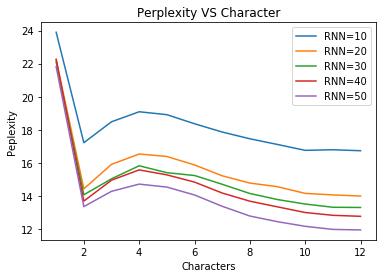

In [5]:
RNN_values = [10,20,30,40,50]
generate_plot(RNN_values)